In [1]:
!pip install paddlepaddle paddleocr gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 16.2 MB/s eta 0:00:00
   ━━

--2025-01-27 03:16:22--  https://github.com/PaddlePaddle/PaddleOCR/raw/release/2.6/doc/fonts/simfang.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PaddlePaddle/PaddleOCR/release/2.6/doc/fonts/simfang.ttf [following]
--2025-01-27 03:16:22--  https://raw.githubusercontent.com/PaddlePaddle/PaddleOCR/release/2.6/doc/fonts/simfang.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10576012 (10M) [application/octet-stream]
Saving to: ‘simfang.ttf’

simfang.ttf         100%[===================>]  10.09M  57.8MB/s    in 0.2s    

2025-01-27 03:16:23 (57.8 MB/s) - ‘simfang.ttf’ saved [10576012/105

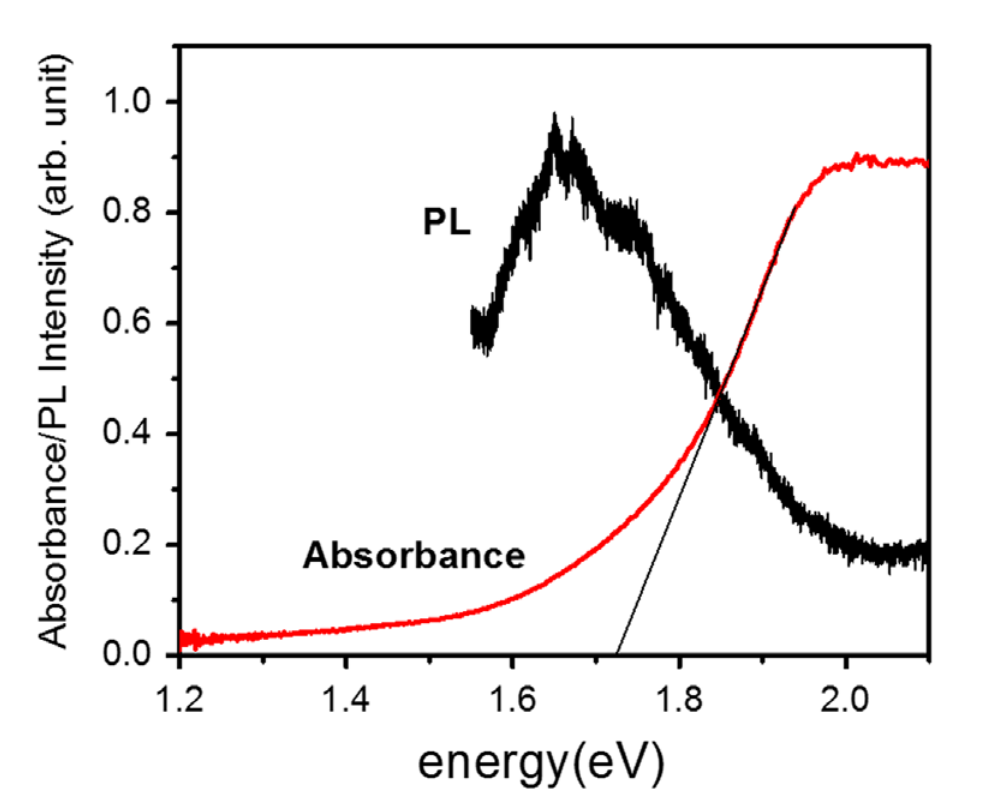

In [3]:
# Download the font file
!wget -O simfang.ttf https://github.com/PaddlePaddle/PaddleOCR/raw/release/2.6/doc/fonts/simfang.ttf

# download example graph
!wget -O example.png https://raw.githubusercontent.com/HaoleiH/AI-driven-projects/refs/heads/main/line_plot_digitizer/example3.png
from IPython.display import Image as Image2
display(Image2('example.png'))

In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import pandas as pd
import gradio as gr
from paddleocr import PaddleOCR, draw_ocr



def hex_to_rgb(hex_color):
    """
    Convert a hexadecimal color string to an (R, G, B) tuple.

    Args:
        hex_color (str): Hexadecimal color string (e.g., "#FFFFFF" or "FFFFFF").

    Returns:
        tuple: Corresponding (R, G, B) tuple.
    """
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def find_color_coordinates(image_path, hex_color, threshold):
    """
    Load an image and find the coordinates of pixels matching a specified color within a given Euclidean distance.

    Args:
        image_path (str): Path to the image file.
        hex_color (str): Target color as a hexadecimal string (e.g., "#FFFFFF").
        threshold (float): Euclidean distance threshold for matching the color.

    Returns:
        list: List of (x, y) coordinates where the color matches.
    """
    # Convert hex color to RGB
    target_color = np.array(hex_to_rgb(hex_color))

    # Load the image and convert to RGB
    img_array = np.array(Image.open(image_path).convert("RGB"))

    # Compute the squared Euclidean distance for efficiency
    distances_sq = np.sum((img_array - target_color) ** 2, axis=-1)

    # Create a mask for pixels within the distance threshold
    mask = distances_sq <= threshold ** 2

    # Extract matching pixel coordinates
    coordinates = np.argwhere(mask)[:, [1, 0]].tolist()  # Convert (row, col) to (x, y)

    return coordinates



def perform_ocr(img_path, font_path, lang='en'):
    """
    Perform OCR on the given image and display results.

    Args:
        img_path (str): Path to the image file.
        font_path (str): Path to the font file for rendering text.
        lang (str): Language for OCR model (default is 'en').

    Returns:
        None
    """
    # Initialize the PaddleOCR model
    ocr = PaddleOCR(use_angle_cls=True, lang=lang)

    # Perform OCR
    results = ocr.ocr(img_path, cls=True)

    if not results:
        print("No text detected in the image.")
        return

    # Process OCR results
    result = results[0]  # Assuming single image input
    boxes = [line[0] for line in result]  # Bounding boxes
    texts = [line[1][0] for line in result]  # Detected texts
    scores = [line[1][1] for line in result]  # Confidence scores

    # Print OCR results
    print("\nDetected Texts and Confidence Scores:")
    for text, score in zip(texts, scores):
        print(f"Text: '{text}', Confidence: {score:.2f}")

    # Visualize OCR results
    image = Image.open(img_path).convert('RGB')
    annotated_image = draw_ocr(image, boxes, texts, scores, font_path=font_path)
    annotated_image = Image.fromarray(annotated_image)

    # Display the resulting image
    display(annotated_image)
    return result




def is_pure_number(s: str) -> bool:
    """
    Checks if the given string is a pure number.
    A pure number can be:
    - Integer (e.g., "1000")
    - Number with commas (e.g., "1,000")
    - Scientific notation (e.g., "1E13", "1.2e-5")

    :param s: The string to check.
    :return: True if the string is a pure number, False otherwise.
    """
    # Regular expression to match pure numbers
    number_pattern = re.compile(
        r'^(\d{1,3}(,\d{3})*|\d+)(\.\d+)?([eE][-+]?\d+)?$'
    )

    # Strip any whitespace and match the pattern
    s = s.strip()
    return bool(number_pattern.match(s))




def group_rectangles(rectangles, tolerance=5):
    """
    Group rectangles by similar x and y coordinates within a specified tolerance.

    Args:
        rectangles (list): List of rectangles, each defined as a list of (x, y) tuples.
        tolerance (int): Tolerance value for grouping coordinates.

    Returns:
        tuple: Two lists of grouped rectangle indices, one for x-coordinates and one for y-coordinates.
    """
    # Initialize groups
    x_groups = defaultdict(list)
    y_groups = defaultdict(list)

    for i, rect in enumerate(rectangles):
        # Compute mean x and y coordinates for the rectangle
        x_mean = np.mean([point[0] for point in rect])
        y_mean = np.mean([point[1] for point in rect])

        # Group by x
        added_to_x = False
        for key in list(x_groups.keys()):  # Avoid modifying the dictionary during iteration
            if abs(key - x_mean) <= tolerance:
                x_groups[key].append(i)
                added_to_x = True
                break
        if not added_to_x:
            x_groups[x_mean].append(i)

        # Group by y
        added_to_y = False
        for key in list(y_groups.keys()):
            if abs(key - y_mean) <= tolerance:
                y_groups[key].append(i)
                added_to_y = True
                break
        if not added_to_y:
            y_groups[y_mean].append(i)

    # Sort groups by size in descending order
    x_group_list = sorted(x_groups.values(), key=len, reverse=True)
    y_group_list = sorted(y_groups.values(), key=len, reverse=True)

    return x_group_list, y_group_list




def transform_coordinates(curve_x, curve_y, x1, y1, x2, y2, l1, l2):
    """
    Transforms coordinates of a curve from an old system to a new one.

    Args:
        curve_x (array): X-coordinates of the curve in the old system.
        curve_y (array): Y-coordinates of the curve in the old system.
        x1, y1 (float): Coordinates of a known point in the old system.
        x2, y2 (float): Coordinates of the same point in the new system.
        l1, l2 (float): Scale factors for x and y axes.

    Returns:
        tuple: Transformed x and y coordinates in the new system.
    """
    displacement_x = x2 - (x1 * l1)
    displacement_y = y2 - (y1 * l2)

    transformed_x = (curve_x * l1) + displacement_x
    transformed_y = (curve_y * l2) + displacement_y

    return transformed_x, transformed_y


header='''
<header style="width: 100%; text-align: center; padding: 30px 20px; background: linear-gradient(135deg, #6a11cb, #2575fc); color: white; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
  <h1 style="font-size: 2.5rem; margin-bottom: 15px;">Graph Digitizer</h1>
  <p style="font-size: 1.2rem; margin-bottom: 25px; line-height: 1.5; max-width: 800px; margin-left: auto; margin-right: auto;">
    A straightforward tool designed to extract data point positions from colored line plots.
  </p>
  <div style="display: flex; justify-content: center; gap: 15px;">
    <a href="https://github.com/your-repo-link" target="_blank" style="text-decoration: none;">
      <img src="https://img.shields.io/badge/GitHub-View%20on%20GitHub-black?logo=github&style=for-the-badge"
           alt="GitHub Badge" style="vertical-align: middle;">
    </a>
    <a href="https://colab.research.google.com/your-colab-link" target="_blank" style="text-decoration: none;">
      <img src="https://img.shields.io/badge/Colab-Open%20in%20Google%20Colab-orange?logo=googlecolab&style=for-the-badge"
           alt="Colab Badge" style="vertical-align: middle;">
    </a>
  </div>
</header>
'''


# gradio app
def process_image(image, target_color, threshold):
    # Save the uploaded image
    image_path = "uploaded_image.png"
    image.save(image_path)

    # Find coordinates of matching pixels
    coordinates = np.array(find_color_coordinates(image_path, target_color, threshold))

    # paddle ocr
    # Download the font file
    !wget -O simfang.ttf https://github.com/PaddlePaddle/PaddleOCR/raw/release/2.6/doc/fonts/simfang.ttf
    FONT_PATH = 'simfang.ttf'  # Path to the font file for drawing text
    LANG = 'en'  # Language for OCR: 'en', 'ch', etc.
    result = perform_ocr(image_path, FONT_PATH, LANG)

    # Extract axis labels
    axis_label = [res for res in result if is_pure_number(res[1][0])]

    # group retangles by x and y axis
    rectangles = [i[0] for i in axis_label]
    x_groups, y_groups = group_rectangles(rectangles, tolerance=5)

    # final result calculation
    # Extract real and pixel coordinates for the y-axis
    yaxis_real = [float(axis_label[i][1][0]) for i in x_groups[0]]
    yaxis_pixel = [np.mean(axis_label[i][0], axis=0)[1] for i in x_groups[0]]

    # Compute y-axis pixel-to-distance conversion
    y_pixel_to_distance = np.polyfit(yaxis_pixel, yaxis_real, 1)[0]

    # Extract real and pixel coordinates for the x-axis
    xaxis_real = [float(axis_label[i][1][0]) for i in y_groups[0]]
    xaxis_pixel = [np.mean(axis_label[i][0], axis=0)[0] for i in y_groups[0]]

    # Compute x-axis pixel-to-distance conversion
    x_pixel_to_distance = np.polyfit(xaxis_pixel, xaxis_real, 1)[0]

    # Generate mesh grids for real and pixel coordinates
    mesh_real_x, mesh_real_y = np.meshgrid(xaxis_real, yaxis_real)
    mesh_pixel_x, mesh_pixel_y = np.meshgrid(xaxis_pixel, yaxis_pixel)

    # Curve coordinates in pixel space
    curve_pixel_x, curve_pixel_y = coordinates[:, 0], coordinates[:, 1]

    # Transform curve coordinates from pixel space to real space
    curve_real_x, curve_real_y = transform_coordinates(
        curve_pixel_x, curve_pixel_y,
        mesh_pixel_x[0, 0], mesh_pixel_y[0, 0],
        mesh_real_x[0, 0], mesh_real_y[0, 0],
        x_pixel_to_distance, y_pixel_to_distance
    )

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Pixel space visualization
    ax[0].imshow(Image.open(image_path))
    ax[0].scatter(mesh_pixel_x, mesh_pixel_y, label="Pixel Grid")
    ax[0].scatter(mesh_pixel_x[0, 0], mesh_pixel_y[0, 0], color="r", label="Origin")
    ax[0].axis('off')
    ax[0].legend().set_visible(False)
    ax[0].set_title("Pixel Space")

    # Real space visualization
    ax[1].scatter(mesh_real_x, mesh_real_y, label="Real Grid")
    ax[1].scatter(mesh_real_x[0, 0], mesh_real_y[0, 0], color="r", label="Origin")
    ax[1].scatter(curve_real_x, curve_real_y, color="r", label="Transformed Curve")
    ax[1].legend().set_visible(False)
    ax[1].set_title("Real Space")
    fig.savefig("output.png")



    final_data=pd.DataFrame({"x":curve_real_x,"y":curve_real_y})
    final_data.to_csv("final_data.csv",index=False)
    output_str = final_data.to_string(index=False)
    return "final_data.csv", "output.png"




def create_app():
    with gr.Blocks() as app:
        gr.HTML(header)
        with gr.Row():
            with gr.Column(scale=5):
                with gr.Row():
                    image_input = gr.Image(type="pil", label="Upload plot",height=400, width=400)
                with gr.Row():
                    color_input = gr.ColorPicker(label="Target Color")
                    threshold_slider = gr.Slider(1, 100, value=50, step=1, label="Threshold")
                submit_button = gr.Button("Process")
            with gr.Column(scale=5):
                with gr.Row():
                    output_image = gr.Image(label="Detected Pixels")
                with gr.Row():
                    output_text = gr.File(label="converted result", interactive=False)#gr.TextArea(label="Output data", lines=45, show_copy_button=True)#gr.Textbox(label="Status", interactive=False)
        submit_button.click(
            process_image,
            inputs=[image_input, color_input, threshold_slider],
            outputs=[output_text, output_image]
        )
        examples = gr.Examples(
        examples=[
            ["/content/example.png", "#fe0404", 50]
        ],
        inputs=[image_input, color_input, threshold_slider],
    )

    return app

if __name__ == "__main__":
    app = create_app()
    app.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6703026ae12f90ca36.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
